<h3>3.2实现神经网络实例</h3>

3.2.1背景说明

![image.png](attachment:image.png)

In [2]:
!pip install tensorboardX

     |████████████████████████████████| 124 kB 12.6 MB/s 


3.2.2准备数据

In [3]:
import numpy as np
import torch
# 导入 pytorch 内置的 mnist 数据
from torchvision.datasets import mnist 
#import torchvision
#导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
#导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

from tensorboardX import SummaryWriter

In [4]:
# 定义一些超参数
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 20

In [5]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])

In [6]:
#定义预处理函数
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
#下载数据，并对数据进行预处理
train_dataset = mnist.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = mnist.MNIST('./data', train=False, transform=transform)
#得到一个生成器
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [8]:
example_data.shape

torch.Size([128, 1, 28, 28])

3.2.3可视化源数据

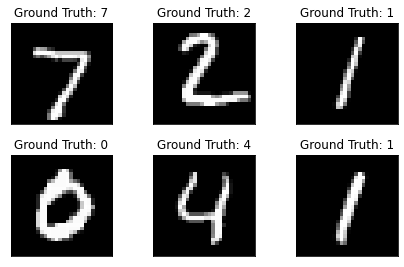

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])


3.2.4 构建模型

In [10]:
class Net(nn.Module):
    """
    使用sequential构建网络，Sequential()函数的功能是将网络的层组合到一起
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1),nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2),nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
        
 
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [11]:
lr = 0.01
momentum = 0.9

In [12]:
#实例化模型
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#if torch.cuda.device_count() > 1:
#    print("Let's use", torch.cuda.device_count(), "GPUs")
#    # dim = 0 [20, xxx] -> [10, ...], [10, ...] on 2GPUs
#    model = nn.DataParallel(model)
model = Net(28 * 28, 300, 100, 10)
model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

3.2.5 训练模型

In [13]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []
writer = SummaryWriter(log_dir='logs',comment='train-loss')

for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    #动态修改参数学习率
    if epoch%5==0:
        optimizer.param_groups[0]['lr']*=0.9
        print(optimizer.param_groups[0]['lr'])
    for img, label in train_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        # 前向传播
        out = model(img)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 保存loss的数据与epoch数值
        writer.add_scalar('Train', train_loss/len(train_loader), epoch)
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc
        
    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    #net.eval() # 将模型改为预测模式
    model.eval()
    for img, label in test_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        out = model(img)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc
        
    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    print('epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'
          .format(epoch, train_loss / len(train_loader), train_acc / len(train_loader), 
                     eval_loss / len(test_loader), eval_acc / len(test_loader)))

0.009000000000000001
epoch: 0, Train Loss: 0.2200, Train Acc: 0.9367, Test Loss: 0.0882, Test Acc: 0.9724
epoch: 1, Train Loss: 0.0864, Train Acc: 0.9740, Test Loss: 0.0714, Test Acc: 0.9776
epoch: 2, Train Loss: 0.0591, Train Acc: 0.9821, Test Loss: 0.0685, Test Acc: 0.9789
epoch: 3, Train Loss: 0.0444, Train Acc: 0.9867, Test Loss: 0.0618, Test Acc: 0.9822
epoch: 4, Train Loss: 0.0337, Train Acc: 0.9899, Test Loss: 0.0637, Test Acc: 0.9803
0.008100000000000001
epoch: 5, Train Loss: 0.0245, Train Acc: 0.9928, Test Loss: 0.0563, Test Acc: 0.9829
epoch: 6, Train Loss: 0.0202, Train Acc: 0.9943, Test Loss: 0.0597, Test Acc: 0.9812
epoch: 7, Train Loss: 0.0186, Train Acc: 0.9943, Test Loss: 0.0595, Test Acc: 0.9821
epoch: 8, Train Loss: 0.0135, Train Acc: 0.9967, Test Loss: 0.0650, Test Acc: 0.9794
epoch: 9, Train Loss: 0.0120, Train Acc: 0.9966, Test Loss: 0.0596, Test Acc: 0.9816
0.007290000000000001
epoch: 10, Train Loss: 0.0090, Train Acc: 0.9979, Test Loss: 0.0555, Test Acc: 0.9831
e

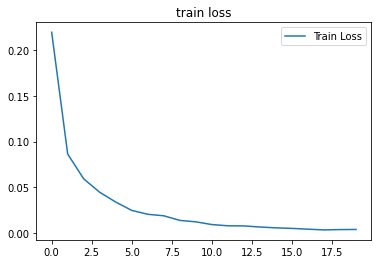

In [14]:
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)
#plt.plot(np.arange(len(eval_losses)), eval_losses)
#plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.legend(['Train Loss'], loc='upper right')


In [15]:
# 将model保存为graph
writer.add_graph(model, (img,))

In [16]:
class Net1(torch.nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.conv = torch.nn.Sequential(
            OrderedDict(
                [
                    ("conv1", torch.nn.Conv2d(3, 32, 3, 1, 1)),
                    ("relu1", torch.nn.ReLU()),
                    ("pool", torch.nn.MaxPool2d(2))
                ]
            ))

        self.dense = torch.nn.Sequential(
            OrderedDict([
                ("dense1", torch.nn.Linear(32 * 3 * 3, 128)),
                ("relu2", torch.nn.ReLU()),
                ("dense2", torch.nn.Linear(128, 10))
            ])
        )


<h3>3.6 优化器</h3>

In [17]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
 
# 超参数
LR = 0.01
BATCH_SIZE = 32
EPOCH = 12
 
# 生成训练数据
# torch.unsqueeze() 的作用是将一维变二维，torch只能处理二维的数据
x = torch.unsqueeze(torch.linspace(-1, 1, 1000), dim=1)  
# 0.1 * torch.normal(x.size())增加噪点
y = x.pow(2) + 0.1 * torch.normal(torch.zeros(*x.size()))
 


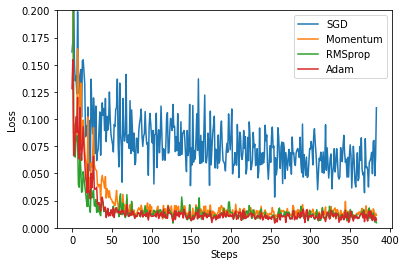

In [18]:
torch_dataset = Data.TensorDataset(x,y)
#得到一个代批量的生成器
loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True)
 
 
class Net2(torch.nn.Module):
    # 初始化
    def __init__(self):
        super(Net2, self).__init__()
        self.hidden = torch.nn.Linear(1, 20)
        self.predict = torch.nn.Linear(20, 1)
 
    # 前向传递
    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x
 
net_SGD = Net2()
net_Momentum = Net2()
net_RMSProp = Net2()
net_Adam = Net2()
 
nets = [net_SGD, net_Momentum, net_RMSProp, net_Adam]
 
opt_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR)
opt_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.9)
opt_RMSProp = torch.optim.RMSprop(net_RMSProp.parameters(), lr=LR, alpha=0.9)
opt_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizers = [opt_SGD, opt_Momentum, opt_RMSProp, opt_Adam]
 
loss_func = torch.nn.MSELoss()
 
loss_his = [[], [], [], []]  # 记录损失
 
for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(loader):
        for net, opt,l_his in zip(nets, optimizers, loss_his):
            output = net(batch_x)  # get output for every net
            loss = loss_func(output, batch_y)  # compute loss for every net
            opt.zero_grad()  # clear gradients for next train
            loss.backward()  # backpropagation, compute gradients
            opt.step()  # apply gradients
            l_his.append(loss.data.numpy())  # loss recoder
labels = ['SGD', 'Momentum', 'RMSprop', 'Adam']
for i, l_his in enumerate(loss_his):
    plt.plot(l_his, label=labels[i])
plt.legend(loc='best')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.ylim((0, 0.2))
plt.show()
